# MoleculeDiffusionTransformer: Forward transformer model (predict molecular properties from SMILES) 

Reference:

#### Generative Discovery of Novel Chemical Designs using Diffusion Modeling and Transformer Architectures with Application to Deep Eutectic Solvents 

Rachel K. Luu1,2, Marcin Wysokowski1 , Markus J. Buehler1,3*

1 Laboratory for Atomistic and Molecular Mechanics (LAMM), Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
2 Department of Materials Science and Engineering, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA
3 Center for Computational Science and Engineering, Schwarzman College of Computing, Massachusetts Institute of Technology, 77 Massachusetts Ave., Cambridge, MA 02139, USA

mbuehler@MIT.EDU 

In [1]:
import os,sys
import math
import matplotlib.pyplot as plt 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def exists(val):
    return val is not None

import torch

from sklearn.model_selection import train_test_split
#from tqdm import tqdm, trange
from tqdm.notebook import trange, tqdm

import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from functools import partial, wraps

In [2]:
from einops import rearrange, repeat

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [4]:
import pandas as pd

from torch.utils.data import DataLoader,Dataset
import pandas as pd
import seaborn as sns
import time

In [5]:
from MoleculeDiffusion import draw_and_save, draw_and_save_set

2023-04-08 20:14:11.256087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 20:14:11.401516: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
print("Torch version:", torch.__version__) 

Torch version: 2.0.0+cu117


In [7]:
#QM9: https://github.com/wengong-jin/chemprop

In [8]:
df=pd.read_csv("qm9_.csv")
 
df.describe()

,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,2.706037,75.191296,-0.239977,0.011124,0.251100,1189.527450,0.148524,31.600676,-411.543985,-411.535513,-411.534569,-411.577397
std,1.530394,8.187793,0.022131,0.046936,0.047519,279.757172,0.033274,4.062471,40.060230,40.060012,40.060012,40.060741
min,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,6.002000,-714.568061,-714.560153,-714.559209,-714.602138
25%,1.588700,70.380000,-0.252500,-0.023800,0.216300,1018.322600,0.125289,28.942000,-437.913936,-437.905942,-437.904997,-437.947682
50%,2.500000,75.500000,-0.241000,0.012000,0.249400,1147.585800,0.148329,31.555000,-417.864758,-417.857351,-417.856407,-417.895731
75%,3.636100,80.520000,-0.228700,0.049200,0.288200,1308.816600,0.171150,34.276000,-387.049166,-387.039746,-387.038802,-387.083279
max,29.556400,196.620000,-0.101700,0.193500,0.622100,3374.753200,0.273944,46.969000,-40.478930,-40.476062,-40.475117,-40.498597


In [9]:
df['smiles']

0                           C
1                           N
2                           O
3                         C#C
4                         C#N
                 ...         
133880    C1C2C3C4C5OC14C5N23
133881    C1N2C3C2C2C4OC12C34
133882    C1N2C3C4C5C2C13CN45
133883    C1N2C3C4C5CC13C2C45
133884    C1N2C3C4C5OC13C2C45
Name: smiles, Length: 133885, dtype: object

In [10]:
df['alpha']


0         13.21
1          9.46
2          6.31
3         16.28
4         12.99
          ...  
133880    69.37
133881    69.52
133882    73.60
133883    77.40
133884    69.48
Name: alpha, Length: 133885, dtype: float64

In [11]:
for col in df.columns:
    print(col)

smiles
mu
alpha
homo
lumo
gap
r2
zpve
cv
u0
u298
h298
g298


In [12]:
df.loc[0,:] [1:].shape, df.iloc[:,:].shape

((12,), (133885, 13))

In [13]:
y_data=df.iloc [:, 1: ] .to_numpy()
y_data.shape

(133885, 12)

In [14]:
# labels for y

In [15]:
col_names=df.columns[1:]
col_names 

Index(['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'cv', 'u0', 'u298',
       'h298', 'g298'],
      dtype='object')

In [16]:
col_names[1]

'alpha'

### Smiles to Image

In [17]:
#!pip install rdkit

In [18]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor
from PIL import Image



rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize=20


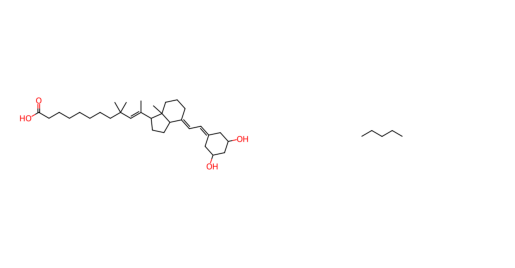

In [19]:
draw_and_save_set (smiles = ['CC(=CC(C)(C)CCCCCCCC(=O)O)C1CCC2C(=CC=C3CC(O)CC(O)C3)CCCC21C',
                                 'CCCC(C)'],
                   fname='out.png',
                    plot_title=None,
                  figsize=1,
                       mols_per_row=2,
                )

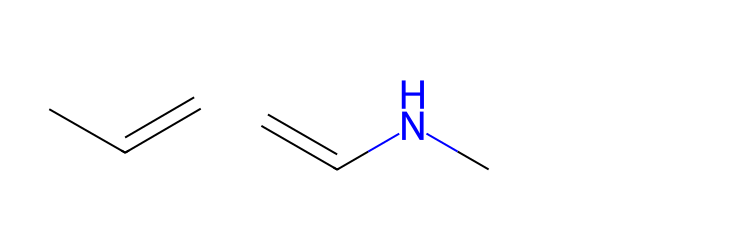

In [20]:
molecule1 = Chem.MolFromSmiles('CC=C')
molecule2 = Chem.MolFromSmiles('CNC=C')
Draw.MolsToGridImage((molecule1,molecule2), subImgSize=(250,250))

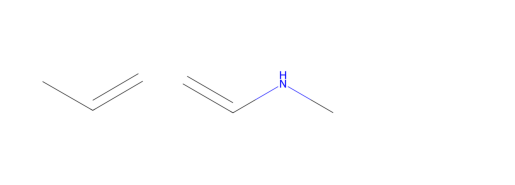

True

In [21]:
draw_and_save (smi = 'CC=C', GTsmile = 'CNC=C', fname='out.png', add_Hs=True)

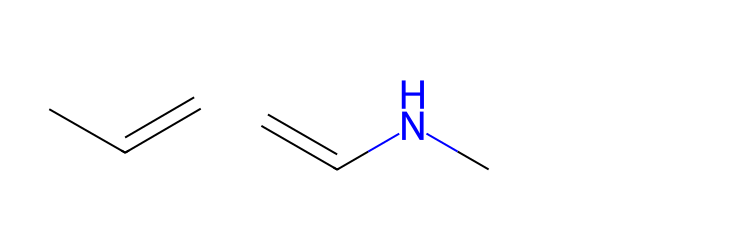

In [22]:
Draw.MolsToGridImage((molecule1,molecule2), subImgSize=(250,250))

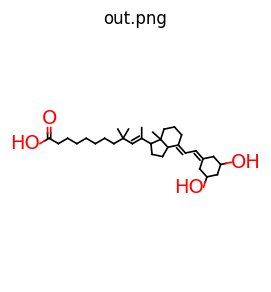

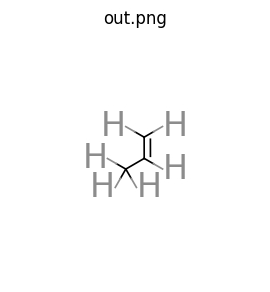

True

In [23]:
draw_and_save (smi = 'CC(=CC(C)(C)CCCCCCCC(=O)O)C1CCC2C(=CC=C3CC(O)CC(O)C3)CCCC21C', fname='out.png')
draw_and_save (smi = 'CC=C', fname='out.png', add_Hs=True)




### Normalize properties

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) 
y_data = scaler.fit_transform(y_data, )  #array-like of shape (n_samples, n_features)
y_data.shape


(133885, 12)

In [25]:
context_embedding_max_length=y_data.shape[1]
context_embedding_max_length

12

In [26]:
scaler

MinMaxScaler(feature_range=(-1, 1))

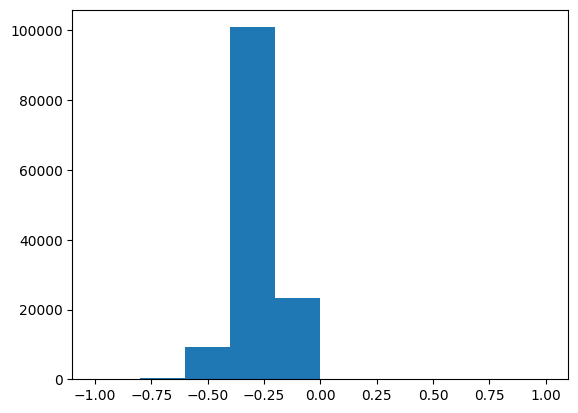

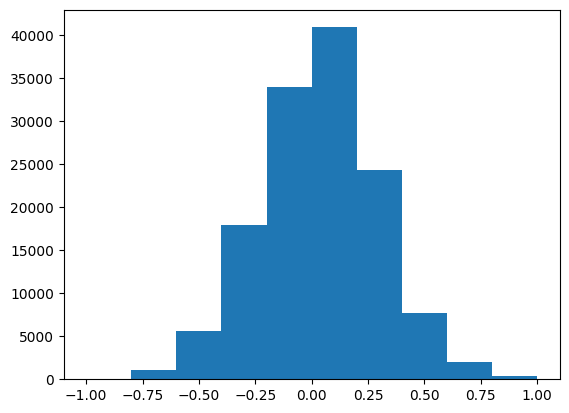

In [27]:
plt.hist (y_data[:,1])
plt.show()
plt.hist (y_data[:,6])
plt.show()

In [28]:
X_data_temp= df['smiles']
start_char='@'
end_char='$'

X_data=[]
for i in range (len (X_data_temp)):
    X_data.append (start_char+X_data_temp[i]+end_char)


### Dataset loader 

In [29]:

class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
       
    def __getitem__(self, index):
        
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [30]:
def pad_sequence_end (output_xyz, max_length_l):         #pad
    output=torch.zeros((output_xyz.shape[0] , max_length_l,  output_xyz.shape[2])).to(device)
    output[:,:output_xyz.shape[-2],:]=output_xyz  
    return output.to(device)


In [31]:
def get_data_loaders (X_scaled,  y_data_scaled,  split=0.1, batch_size_=16):

    X_train, X_test, y_train, y_test,     = train_test_split(torch.Tensor (X_scaled),    torch.Tensor (y_data_scaled) ,
                                                             test_size=split,random_state=235)

    print (f"Shapes= {X_scaled.shape}, {y_data_scaled.shape}")
     
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    train_dataset = RegressionDataset(X_train, y_train,  ) #/ynormfac)

    test_dataset = RegressionDataset(X_test,y_test, )
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=True)
    train_loader_noshuffle = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size_)

    return train_loader,train_loader_noshuffle, test_loader

In [32]:
res = max(X_data[:], key = len)
max_length_data=len (res)
max_length=max (max_length_data, 64)

# printing result
print("Maximum length string is : " , res, "length=",max_length_data, "chosen length=", max_length)

Maximum length string is :  @c1(=O)[nH]c(=O)[nH]c(=O)[nH]1$ length= 31 chosen length= 64


In [33]:
X_data[:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [34]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
filters=''# '!"$%&()*+,-./:;<=>?[\\]^_`{|}\t\n'

tokenizer_X = Tokenizer(char_level=True, filters=filters, lower=False)
tokenizer_X.fit_on_texts(X_data)
        
X_data_tokenized = tokenizer_X.texts_to_sequences(X_data)

X_data_tokenized= sequence.pad_sequences(X_data_tokenized,  maxlen=max_length, padding='post', truncating='post') 


In [35]:
filters=''# '!"$%&()*+,-./:;<=>?[\\]^_`{|}\t\n'

tokenizer_X = Tokenizer(char_level=True, filters=filters, lower=False)
tokenizer_X.fit_on_texts(X_data)
        
X_data_tokenized = tokenizer_X.texts_to_sequences(X_data)

X_data_tokenized= sequence.pad_sequences(X_data_tokenized,  maxlen=max_length, padding='post', truncating='post')  

In [36]:
#generate start token

start_char_token= tokenizer_X.texts_to_sequences( start_char )
start_char_token

[[4]]

In [37]:
end_char_token= tokenizer_X.texts_to_sequences( end_char )
end_char_token

[[5]]

In [38]:
def reverse_tokenize (tokenizer_X, X_data, X_norm_factor=1):
    #X_data_tokenized_reversed[:12]
    X_data_tokenized_reversed=tokenizer_X.sequences_to_texts ( (X_data*X_norm_factor).astype(int) )
    k = []
    ## k = lambda: [num.strip() for num in X_data_tokenized_reversed]
    #k = lambda: [num.replace(' ', '') for num in X_data_tokenized_reversed]
    for i in X_data_tokenized_reversed:
        i=str(i).replace(' ','')
        #print (i)
        k.append(i)
    return k


In [39]:
print ("#################################")
print ("DICTIONARY y_data")
dictt=tokenizer_X.get_config()
print (dictt)
print ("Length dictionary: ", len (dictt) )
num_words = len(tokenizer_X.word_index) + 1
num_words


#################################
DICTIONARY y_data
{'num_words': None, 'filters': '', 'lower': False, 'split': ' ', 'char_level': True, 'oov_token': None, 'document_count': 133885, 'word_counts': '{"@": 133885, "C": 787482, "$": 133885, "N": 109306, "O": 181161, "#": 37027, "=": 106335, "(": 126532, ")": 126532, "1": 270020, "c": 59074, "[": 9918, "n": 30458, "H": 8247, "]": 9918, "o": 6836, "3": 34756, "+": 1705, "-": 1808, "2": 121675, "F": 3314, "4": 5186, "5": 242}', 'word_docs': '{"$": 133885, "@": 133885, "C": 131656, "N": 74300, "O": 111215, "#": 32432, "=": 76005, "(": 92249, ")": 92249, "1": 119887, "H": 7941, "]": 7941, "n": 16002, "[": 7941, "c": 17698, "o": 6546, "+": 1705, "-": 1808, "3": 17627, "2": 60295, "F": 2163, "4": 2593, "5": 121}', 'index_docs': '{"5": 133885, "4": 133885, "1": 131656, "9": 74300, "3": 111215, "12": 32432, "10": 76005, "6": 92249, "7": 92249, "2": 119887, "17": 7941, "16": 7941, "14": 16002, "15": 7941, "11": 17698, "18": 6546, "22": 1705, "21": 

24

In [40]:
X_data_tokenized_reversed=reverse_tokenize (tokenizer_X, X_data_tokenized)

In [41]:
X_data [:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [42]:

X_data_tokenized_reversed[:6]

['@C$', '@N$', '@O$', '@C#C$', '@C#N$', '@C=O$']

In [43]:
X_data_tokenized

array([[4, 1, 5, ..., 0, 0, 0],
       [4, 9, 5, ..., 0, 0, 0],
       [4, 3, 5, ..., 0, 0, 0],
       ...,
       [4, 1, 2, ..., 0, 0, 0],
       [4, 1, 2, ..., 0, 0, 0],
       [4, 1, 2, ..., 0, 0, 0]], dtype=int32)

In [44]:
batch_size_=256
train_loader,train_loader_noshuffle, test_loader= get_data_loaders (X_data_tokenized,  y_data ,  split=0.1, 
                                                                    batch_size_=batch_size_)

print (f"Number of batches in training: {len (train_loader)}")

Shapes= (133885, 64), (133885, 12)
torch.Size([120496, 64])
torch.Size([120496, 12])
torch.Size([13389, 64])
torch.Size([13389, 12])
Number of batches in training: 471


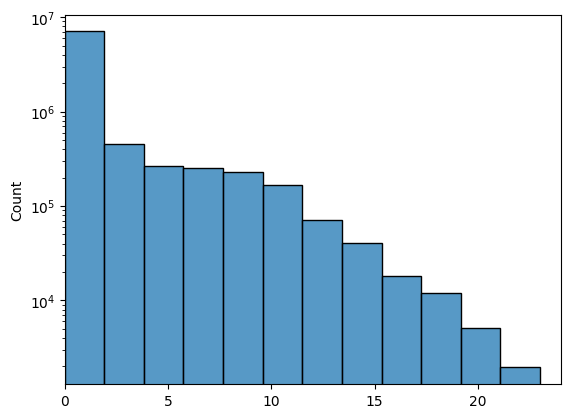

In [45]:
fig_handle =sns.histplot(np.array(X_data_tokenized).flatten(), bins=12,   log_scale=(False, True) )
fig = fig_handle.get_figure()
fig_handle.set_xlim(0, num_words)
#fig_handle.set_ylim(0, 100000)
#plt.xticks(range (1,21))
plt.show()


In [46]:
ALL_SMILES=df['smiles'].values.tolist()
 
def is_novel (ALL_SMILES, smi):
    if smi in ALL_SMILES:
        return False
    else:
        return True

In [47]:
X_data_tokenized.shape

(133885, 64)

### Set up transformer model

In [48]:
import MoleculeDiffusion 
from   MoleculeDiffusion import remove_start_end_token, MoleculeTransformer,MoleculeTransformerSequence, count_parameters,plot_results_as_barchart
from   MoleculeDiffusion import  MoleculeTransformerSequenceEncoder, generate_from_conditioning_transformer,remove_start_end_token_first
from   MoleculeDiffusion import    predict_properties_from_SMILES_transformer, train_loop_forward_transformer, sample_loop_forward_transformer

In [2]:
prefix='./transformer_forward/'
if not os.path.exists(prefix):
        os.mkdir (prefix)

In [50]:
context_embedding_max_length,max_length,num_words

(12, 64, 24)

In [ ]:
train_model=False #True

In [51]:
#max_length=64
context_embedding_max_length=y_data.shape[1]
logits_dim = 1 #
print (logits_dim, context_embedding_max_length)

model_forward = MoleculeTransformerSequenceEncoder(
        dim=256,
        depth=6,
        logits_dim=logits_dim, #logits channels
        logits_dim_length = context_embedding_max_length , #if None entire length is used. Otherwise, max_length is projected to logits_dim_length
                                #  OUTPUT: (b, logits_dim, logits_dim_length)
        max_length = max_length, #  
        dim_head = 16,
        heads = 16,
        dropout = 0.1,
        ff_mult = 2.,
         max_tokens= num_words,
        embed_dim = 16, #for sequence embedding
       padding_token=0, #used for mask generation
        
    #max_text_len = context_embedding_max_length, #max length of conditioning sequence
       # pos_fourier_graph_dim= 32, #entire graph fourier embedding, will be added to logits_dim
              
).to (device)


count_parameters (model_forward)



1 12
----------------------------------------------------------------------------------------------------
Total parameters:  3162496  trainable parameters:  3162496
----------------------------------------------------------------------------------------------------


In [52]:
seq_input=torch.randint (0,num_words, (4, max_length)).cuda()  #batch, 1, length (length is flexible)
print (seq_input.shape)

torch.Size([4, 64])


In [53]:
pred=model_forward(seq_input)
pred.shape

torch.Size([4, 1, 12])

In [ ]:

if train_model:

    optimizer = optim.Adam(model_forward.parameters() , lr=0.0001 )
    
    loss_list=[]
    R2_list=[]

    train_loop_forward_transformer (model_forward,device,
                    train_loader,test_loader,
                    optimizer=optimizer, 
                    prefix=prefix,
                    tokenizer_X=tokenizer_X,
                    print_every=1000,
                    epochs= 3000000,
                    start_ep=0,
                    start_step=0,
                    print_loss=1*len (train_loader),
                    num_samples=256,
                    save_model=True,
                    show_jointplot=True,
                    loss_list=loss_list,
                    R2_list=R2_list,                
                    )
    
else:
    # Load best model
    fname=f'./QM_forward_transformer_2/statedict_save-model-epoch_10.pt' 
    model_forward.load_state_dict(torch.load(fname))

In [ ]:
res, _=predict_properties_from_SMILES_transformer (model_forward,device, SMILES=['C',
                                                                     'CCC',
                                                                     'CCCCCC',
                                                                     'CCCCCCCCC'], 
                scaler=scaler,
                tokenizer_X=tokenizer_X,
                flag=0, 
                draw_molecules=False,
                draw_all=False,
                mols_per_row=8,max_length = 64,
                context_embedding_max_length=12, 
               )

plt.plot (res[:,:])
plt.show()

In [ ]:
sample_loop (model_forward,device,
                test_loader,model_forward=model_forward,
                num_samples=64, #how many samples produced every time tested.....
                tokens_to_generate=max_length-1,show_jointplot=True ,
                draw_molecules=True,
                temperature=1.,
            )

In [ ]:
res, _=predict_properties_from_SMILES_transformer (model_forward,device, SMILES=['C',
                                                                     'CCC',
                                                                     'CCCCCC',
                                                                     'CCCCCCCCC'], 
               # X_norm_factor=X_norm_factor,
                scaler=scaler,
                tokenizer_X=tokenizer_X,
               
             #   cond_scales=[1.], #list of cond scales - each sampled...
                
               # timesteps=100,
                flag=0, 
              #  clamp=False,
                 
                draw_molecules=False,
                draw_all=False,
                mols_per_row=8,max_length = 64,
                                       
                context_embedding_max_length=12, 
               )

plt.plot (res[:,:])
plt.show()